<a href="https://colab.research.google.com/github/Carlosespicur/TFM/blob/main/GAE_UPDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
!pip install torch_geometric
import torch_geometric
!pip install torcheval
import matplotlib.pyplot as plt
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 5.8 MB/s eta 0:00:00


In [2]:
from torch_geometric.nn import GCNConv, GAE, global_mean_pool
from torch.nn import Linear, CrossEntropyLoss
from torch.optim import Adam
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torcheval.metrics import BinaryAccuracy

In [31]:
# Model hyperparameters
hidden_channels = 20
lr = 1e-3
batch_size = 1
num_epochs = 30

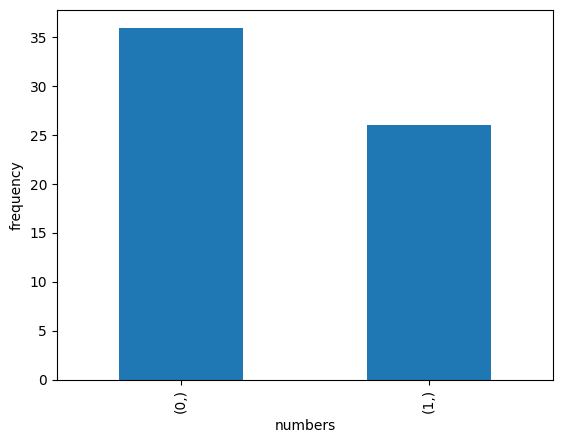

In [32]:
# Data load
from torch_geometric.datasets import UPFD

train_data = UPFD(root = "/content/UPFD_train", name = "politifact", feature = "bert", split = "train") # name = {"politifact", "gossipcop"}, feature = {"profile", "spacy", "bert", "content"}
val_data = UPFD(root = "/content/UPFD_val", name = "politifact", feature = "bert", split = "val")
test_data = UPFD(root = "/content/UPFD_test", name = "politifact", feature = "bert", split = "test")
train_loader = DataLoader(train_data, batch_size, shuffle = True)
val_loader = DataLoader(val_data, batch_size, shuffle = False)
test_loader = DataLoader(test_data, batch_size, shuffle = False)
pd.DataFrame(train_data.y).value_counts().plot(kind='bar', xlabel='numbers', ylabel='frequency')

plt.show()

In [33]:
num_features = train_data.num_node_features
num_classes = train_data.num_classes

In [34]:
# 2-layer GCN encoder, Detector module and complete model

class GCNEncoder(torch.nn.Module):
  def __init__(self, hidden_channels):
    super().__init__()
    self.conv1 = GCNConv(num_features, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, hidden_channels)

  def forward(self, x, edge_index):
    x = self.conv1(x, edge_index)
    x = x.relu()
    x = self.conv2(x, edge_index)
    x = x.relu()

    return x

class Detector(torch.nn.Module):
  def __init__(self, input_size, num_classes):
    super().__init__()
    self.lin = Linear(input_size, num_classes)

  def forward(self, z):
    z = F.dropout(z, p=0.3, training=self.training)
    return self.lin(z)


class GAEDetector(torch.nn.Module):
  def __init__(self, encoder):
    super().__init__()
    self.gae = GAE(encoder)
    self.detector = Detector(hidden_channels, num_classes)
    self.z = torch.zeros(hidden_channels) # encoder output

  def forward(self, x, edge_index):
    self.z = self.gae.encode(x, edge_index)
    output = self.gae.decode(self.z, edge_index)
    return output


In [35]:
encoder = GCNEncoder(hidden_channels)
model = GAEDetector(encoder)

In [36]:
# training and test functions

optimizer = Adam(model.parameters(), lr)
det_criterion = CrossEntropyLoss(reduction = "mean") # Loss function for Detector module
def train():
  model.train()

  for data in train_loader:
    GAE_out = model(data.x, data.edge_index)
    detector_in = global_mean_pool(model.z, data.batch)
    detector_out = model.detector(detector_in) # Unnormalized logits
    loss_GAE =  F.binary_cross_entropy(GAE_out, torch.ones(GAE_out.size(dim = 0))) # Compute binary CE loss of decoder
    loss_detector = det_criterion(detector_out, data.y) # Compute loss of detector module
    loss = loss_GAE + loss_detector
    # print(f"loss_GAE = {loss_GAE}, loss_detector = {loss_detector}, total_loss = {loss}")
    loss.backward() # Compute gradients
    optimizer.step() # Update model parameters
    optimizer.zero_grad() # Clear gradients

def test(data_loader):
  model.eval()

  preds = torch.tensor([]) # vector of all model predictions in current epoch
  labels = torch.tensor([]) # vector of all labels

  for data in data_loader:
    GAE_out = model(data.x, data.edge_index)
    detector_in = global_mean_pool(model.z, data.batch)
    detector_out = model.detector(detector_in)
    pred_labels = torch.argmax(detector_out, dim = 1)
    preds = torch.cat((preds, pred_labels))
    labels = torch.cat((labels, data.y))

  # Compute metrics
  metrics = []
  acc = BinaryAccuracy() # Accuracy
  acc.update(preds, labels)
  metrics.append(acc.compute())

  return metrics


In [37]:
# Model training

for epoch in range(1, num_epochs + 1):
  train()
  train_acc = test(train_loader)[0]
  val_acc = test(val_loader)[0]
  print(f"Epoch: {epoch}, train_acc = {train_acc:.3f}, val_acc = {val_acc:.3f}")


Epoch: 1, train_acc = 0.581, val_acc = 0.419
Epoch: 2, train_acc = 0.581, val_acc = 0.419
Epoch: 3, train_acc = 0.629, val_acc = 0.419
Epoch: 4, train_acc = 0.968, val_acc = 0.806
Epoch: 5, train_acc = 0.887, val_acc = 0.742
Epoch: 6, train_acc = 0.871, val_acc = 0.742
Epoch: 7, train_acc = 0.968, val_acc = 0.742
Epoch: 8, train_acc = 0.935, val_acc = 0.806
Epoch: 9, train_acc = 1.000, val_acc = 0.839
Epoch: 10, train_acc = 0.984, val_acc = 0.774
Epoch: 11, train_acc = 1.000, val_acc = 0.839
Epoch: 12, train_acc = 1.000, val_acc = 0.839
Epoch: 13, train_acc = 1.000, val_acc = 0.806
Epoch: 14, train_acc = 0.903, val_acc = 0.774
Epoch: 15, train_acc = 1.000, val_acc = 0.806
Epoch: 16, train_acc = 0.984, val_acc = 0.839
Epoch: 17, train_acc = 1.000, val_acc = 0.806
Epoch: 18, train_acc = 1.000, val_acc = 0.806
Epoch: 19, train_acc = 1.000, val_acc = 0.871
Epoch: 20, train_acc = 1.000, val_acc = 0.871
Epoch: 21, train_acc = 1.000, val_acc = 0.806
Epoch: 22, train_acc = 1.000, val_acc = 0.8

In [38]:
# Model testing

test_metrics = test(test_loader)
print(f"test_acc = {test_metrics[0]}")

test_acc = 0.8280543088912964
